In [7]:
import pandas as pd
from sqlalchemy import create_engine
import re
from fuzzywuzzy import process
from fuzzywuzzy import fuzz
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from itertools import combinations
from matplotlib_venn import venn2, venn3
import squarify

In [8]:
genre_mapping = {
    'Romance': [
        'manwoman relationships fiction', 'romance general', 'fiction romance', 'fiction romance contemporary', 
        'fiction erotica general', 'romance', 'love', 'romantic comedy', 'romantic suspense', 'historical romance', 
        'romance: contemporary', 'romance: historical', 'romance: regency', 'erotica', 'love stories', 'erotic fiction', 
        'fiction romance general', 'dark fantasy', 'fiction romance suspense', 'romance literature', 
        'fiction romance historical general'
    ],
    'Thriller': [
        'fiction thrillers', 'thriller', 'suspense', 'mystery', 'crime', 'detective', 'psychological thriller', 
        'thrillers & suspense', 'fiction thrillers general', 'fiction thrillers suspense', 'action and adventure fiction', 
        'fiction suspense'
    ],
    'Fantasy': [
        'fiction fantasy general', 'fantasy', 'magic', 'witches', 'wizards', 'epic fantasy', 'urban fantasy', 'westerns', 
        'american drama', 'fantasy fiction', 'imaginary places', 'juvenile fantasy fiction'
    ],
    'Science Fiction': [
        'science fiction', 'sci-fi', 'space opera', 'dystopian', 'cyberpunk', 'good and evil', 'time travel', 
        'alternative history'
    ],
    'Historical Fiction': [
        'fiction historical general', 'historical fiction', 'historical', 'world war ii', 'historical mystery', 
        'alternative history', 'fiction romance historical general'
    ],
    'Young Adult': [
        'young adult', 'teen', 'coming of age', 'ya fiction', 'ya romance', 'teen & young adult', 'young adult fiction', 
        'teenage girls', 'juvenile fiction', 'dark fantasy', 'homosexuality', 'good and evil', 'friendship'
    ],
    'Horror': [
        'horror', 'supernatural', 'vampires', 'zombies', 'ghosts', 'post apocalyptic', 'gothic', 'horror fiction', 
        'horror tales', 'fiction horror'
    ],
    'Mystery': [
        'fiction mystery detective general', 'mystery', 'detective', 'crime', 'cozy mystery', 'whodunit', 'women sleuths', 
        'detective stories', 'mystery and detective stories', 'fiction mystery & detective traditional', 'crime novel'
    ],
    'Adventure': [
        'adventure', 'action', 'quest', 'treasure hunt', 'exploration', 'action & adventure', 'action and adventure fiction', 
        'fiction action adventure'
    ],
    'Literary Fiction': [
        'general literary fiction', 'literary fiction', 'contemporary fiction', 'realistic fiction', 'literature & fiction', 
        'american drama', 'romans, nouvelles', 'epic', 'epic literature', 'novel', 'hindu mythology', 'homosexuality', 
        'fiction in english', 'fiction lgbtq gay', 'fiction', 'fiction short stories single author', 'fiction humorous general'
    ],
    'Humor': [
        'humor', 'comedy', 'satire', 'funny', 'parody'
    ],
    'Biography': [
        'biography', 'autobiography', 'memoir', 'personal memoir', 'life story'
    ],
    'Classics': [
        'classics', 'literature - classics / criticism'
    ],
    'Children': [
        'short stories', 'child and youth fiction', 'comics graphic novels general', 'childrens fiction', 'child', 'children', 
        'reading level grade 9', 'reading level grade 8', 'reading level grade 11', 'reading level grade 10', 
        'reading level grade 12', 'comics', 'comic books, strips', 'friendship', 'juvenile', 'family'
    ],
    'General': [
        'fiction general', 'fiction lgbtq gay', 'comics graphic novels general', 'fiction', 'general', 
        'general literary fiction'
    ],
    'Other': [
        'non-classifiable', 'nonclassifiable', 'sale books', 'nonfiction general', 'nonfiction general'
    ]  # Default category for remaining genres
}

In [9]:
def preprocess_genre(genre):
    # Convert to lowercase
    genre = genre.lower()
    # Remove special characters and extra whitespace
    genre = re.sub(r'[^\w\s]', '', genre)
    genre = re.sub(r'\s+', ' ', genre)
    # Split by comma and strip whitespace
    genre_list = [g.strip() for g in genre.split(',') if g.strip()]
    return genre_list

In [10]:
def process_genre(genre):
    # Split the genre string by '||' and remove leading and trailing '|'
    genre_list = [g.strip('|') for g in genre.split('||')]
    return genre_list

In [11]:
def clean_genre(genre_list):
    # Clean up each genre in the genre list
    clean_list = []
    for genre in genre_list:
        # Convert to lowercase
        genre = genre.lower()
        # Remove special characters and extra spaces
        genre = re.sub(r'[^a-zA-Z0-9\s]', '', genre)
        genre = re.sub(r'\s+', ' ', genre).strip()
        clean_list.append(genre)
    return clean_list

In [12]:
def match_genre(genre_label, genre_mapping):
    matched_genres = set()  # Use a set to avoid duplicate categories
    
    # Iterate over each key-value pair in genre_mapping
    for category, value in genre_mapping.items():
        # Check for substring matches in the genre_label for each value
        for genre in value:
            if genre in genre_label:
                # If a match is found, add the corresponding category to matched_genres
                matched_genres.add(category)
                break  # Break out of inner loop if a match is found
    
    # Iterate over each category and its corresponding list of genres in the genre_mapping dictionary
    for category, genres in genre_mapping.items():
        # Check for exact matches
        for genre in genres:
            if genre in genre_label:
                # If a match is found, add the corresponding category to matched_genres
                matched_genres.add(category)
                break  # Break out of inner loop if a match is found

    for category, genres in genre_mapping.items():
        for genre in genres:
            # Adjust the fuzzy matching threshold to be more inclusive
            if fuzz.token_sort_ratio(genre_label, genre) > 67:
                # If a match is found, add the corresponding category to matched_genres
                matched_genres.add(category)

    # If no match is found, assign the default category "Other"
    if not matched_genres:
        matched_genres.add('Other')
        
    return list(matched_genres)  # Convert set back to list for consistency


In [13]:
user = 'root'
password = 'nats'
host = 'localhost'
port = '3306' 
database = 'BookMate'

In [29]:
engine = create_engine(f'mysql+pymysql://{user}:{password}@{host}:{port}/{database}')
query = 'SELECT * FROM book LIMIT 500000'
df_books = pd.read_sql(query, engine)

In [30]:
df_books['genre_list'] = df_books['Genres'].apply(lambda x: process_genre(x))

In [31]:
df_books['clean_genre_list'] = df_books['genre_list'].apply(lambda x: clean_genre(x))

In [32]:
df_books['broad_genre'] = df_books['clean_genre_list'].apply(match_genre, args=(genre_mapping,))

In [33]:
df_books['clean_genre_list']

0         [brothers and sisters fiction, twins fiction, ...
1         [large type books, england social life and cus...
2         [borrowing and lending fiction, neighbors fict...
3         [people places africa, juvenile nonfiction, ch...
4         [short stories, general, juvenile fiction, chi...
                                ...                        
499995                                  [childrens fiction]
499996    [women horse owners fiction, horse farms ficti...
499997                                    [fiction general]
499998    [fiction fantasy general, fiction action adven...
499999                                  [childrens fiction]
Name: clean_genre_list, Length: 500000, dtype: object

In [34]:
genre_counts = df_books['broad_genre'].value_counts()
top_genres = genre_counts.head(50)
print(top_genres)

broad_genre
[Other]                                                                                                      115709
[General, Literary Fiction]                                                                                   55321
[Children]                                                                                                    42893
[Thriller, General, Historical Fiction, Romance, Literary Fiction]                                            27044
[Romance]                                                                                                     17582
[Thriller, General, Fantasy, Historical Fiction, Young Adult, Romance, Literary Fiction, Science Fiction]     16751
[General]                                                                                                     12352
[Young Adult]                                                                                                 11884
[Historical Fiction, Romance]                               

In [ ]:
# genre_counts = df_books['clean_genre_list'].value_counts()

In [ ]:
# top_genres = genre_counts.head(100)
# print(top_genres)

In [35]:
df_books

,Title,ISBN,Genres,genre_list,clean_genre_list,broad_genre
0,Orcas Island mystery,,|Brothers and sisters -- Fiction.||Twins -- Fi...,"[Brothers and sisters -- Fiction., Twins -- Fi...","[brothers and sisters fiction, twins fiction, ...",[Mystery]
1,Say you love me,,|Large type books||England -- Social life and ...,"[Large type books, England -- Social life and ...","[large type books, england social life and cus...",[Other]
2,Matilda the moocher,,|Borrowing and lending -- Fiction.||Neighbors ...,"[Borrowing and lending -- Fiction., Neighbors ...","[borrowing and lending fiction, neighbors fict...",[Other]
3,World Studies,9780131669697,|People & Places - Africa||Juvenile Nonfiction...,"[People & Places - Africa, Juvenile Nonfiction...","[people places africa, juvenile nonfiction, ch...",[Other]
4,Puffin Bk of Stories for 7 Yr-Olds,9780140374605,|Short stories||General||Juvenile Fiction||Chi...,"[Short stories, General, Juvenile Fiction, Chi...","[short stories, general, juvenile fiction, chi...","[Young Adult, General, Children]"
...,...,...,...,...,...,...
499995,Blissful Kidz - Stories of Mahashivaratri,9781638489924,Children's fiction\r,[Children's fiction\r],[childrens fiction],[Children]
499996,Reunited,,|Women horse owners -- Fiction.||Horse farms -...,"[Women horse owners -- Fiction., Horse farms -...","[women horse owners fiction, horse farms ficti...",[Other]
499997,Humanity's Struggle,9781638373438,"Fiction, general\r","[Fiction, general\r]",[fiction general],"[Thriller, General, Fantasy, Historical Fictio..."
499998,Magicians of Ysavar,9798985333008,"|Fiction, fantasy, general||Fiction, action & ...","[Fiction, fantasy, general, Fiction, action & ...","[fiction fantasy general, fiction action adven...","[Thriller, Adventure, Fantasy]"


In [36]:
all_genres = [genre for sublist in df_books['broad_genre'] for genre in sublist]

In [44]:
all_genres

['Mystery',
 'Other',
 'Other',
 'Other',
 'Young Adult',
 'General',
 'Children',
 'Young Adult',
 'Literary Fiction',
 'General',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'Other',
 'General',
 'Literary Fiction',
 'Other',
 'General',
 'General',
 'General',
 'Literary Fiction',
 'General',
 'Literary Fiction',
 'Children',
 'General',
 'Other',
 'General',
 'Literary Fiction',
 'Mystery',
 'General',
 'Literary Fiction',
 'Fantasy',
 'Historical Fiction',
 'Romance',
 'General',
 'Literary Fiction',
 'Romance',
 'General',
 'Literary Fiction',
 'Romance',
 'Historical Fiction',
 'Romance',
 'Young Adult',
 'Romance',
 'Children',
 'Young Adult',
 'Literary Fiction',
 'General',
 'Young Adult',
 'General',
 'Young Adult',
 'Children',
 'General',
 'Young Adult',
 'Literary Fiction',
 'General',
 'General',
 'Literary Fiction',
 'Thriller',
 'General',
 'Fantasy',
 'Romance',
 'Literary Fiction',
 'Thriller',
 'General',
 'Historical Fiction',
 'Romance',
 'Literary Fiction'

In [37]:
genre_counts = Counter(all_genres)
genre_df = pd.DataFrame(genre_counts.items(), columns=['Genre', 'Count'])

In [59]:
genre_df

,Genre,Count
0,Mystery,32132
1,Other,122392
2,Young Adult,60312
3,General,210062
4,Children,68072
5,Literary Fiction,185785
6,Fantasy,55182
7,Historical Fiction,76165
8,Romance,130423
9,Thriller,85972


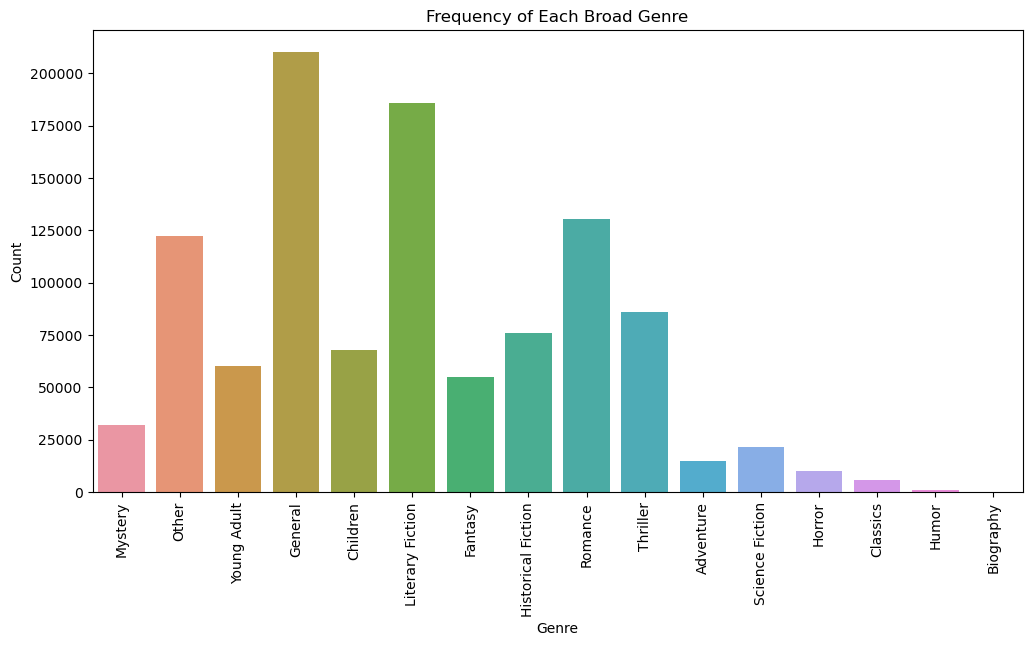

In [60]:
plt.figure(figsize=(12, 6))
sns.barplot(data=genre_df, x='Genre', y='Count')
plt.title('Frequency of Each Broad Genre')
plt.xticks(rotation=90)
plt.show()

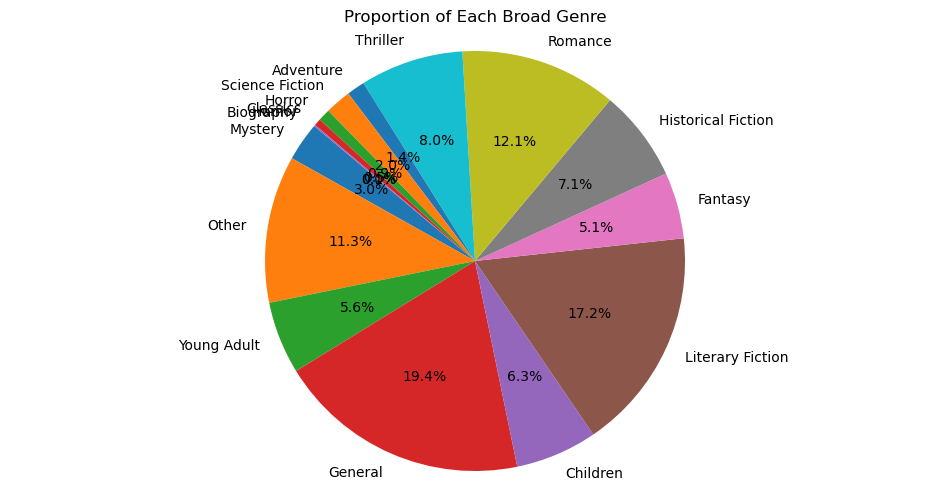

In [61]:
plt.figure(figsize=(12, 6))
plt.pie(genre_df['Count'], labels=genre_df['Genre'], autopct='%1.1f%%', startangle=140)
plt.title('Proportion of Each Broad Genre')
plt.axis('equal')  
plt.show()

In [62]:
overlap_matrix = pd.DataFrame(index=genre_df['Genre'], columns=genre_df['Genre']).fillna(0)
for genres in df_books['broad_genre']:
    for genre1, genre2 in combinations(genres, 2):
        overlap_matrix.at[genre1, genre2] += 1
        overlap_matrix.at[genre2, genre1] += 1

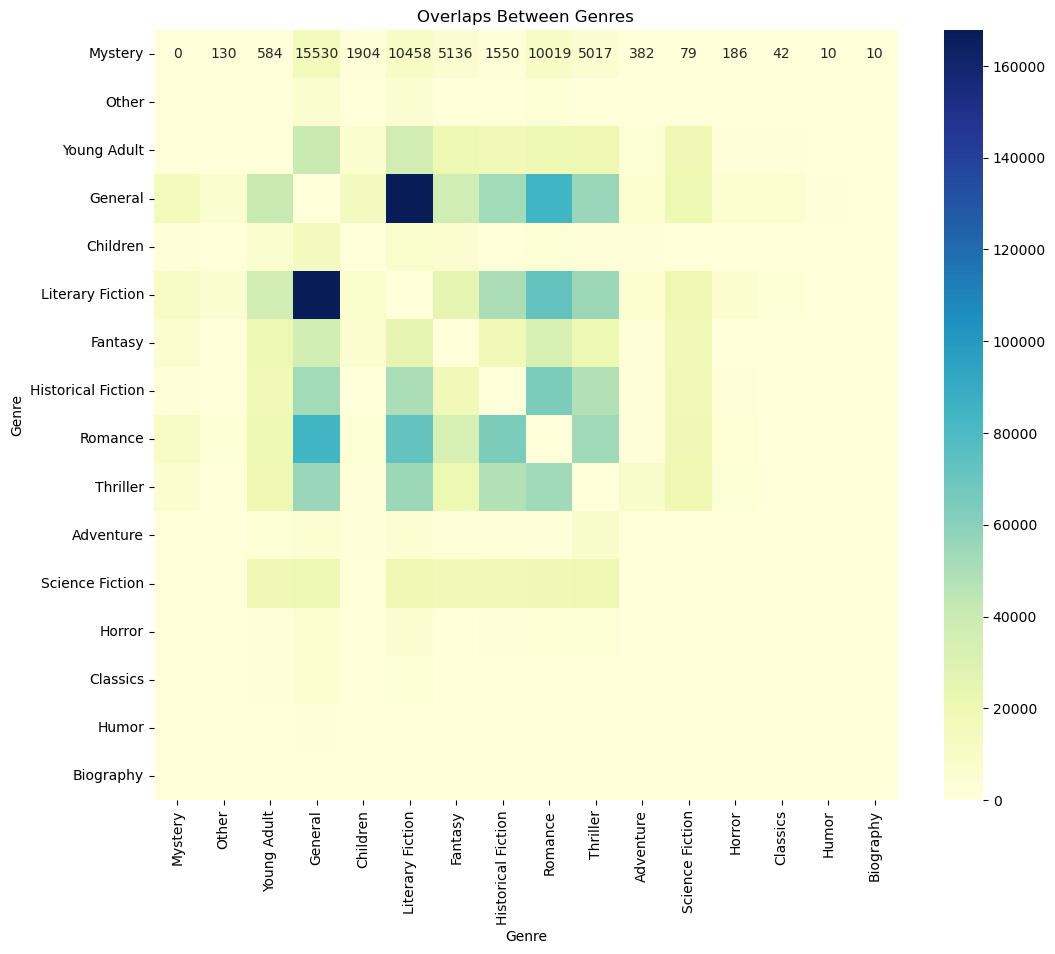

In [41]:
plt.figure(figsize=(12, 10))
sns.heatmap(overlap_matrix, annot=True, fmt="d", cmap="YlGnBu")
plt.title('Overlaps Between Genres')
plt.show()

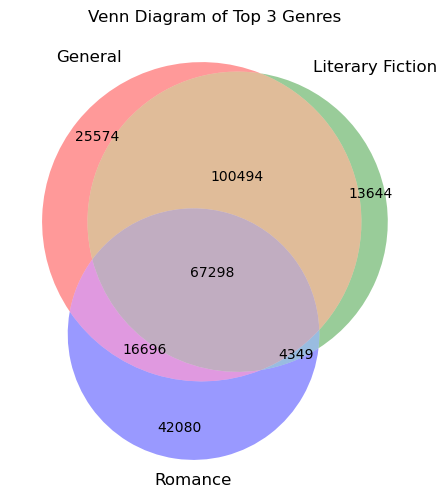

In [42]:
top_genres = genre_df.nlargest(3, 'Count')['Genre']
sets = [set(df_books[df_books['broad_genre'].apply(lambda x: genre in x)].index) for genre in top_genres]

plt.figure(figsize=(10, 6))
venn3(sets, set_labels=top_genres)
plt.title('Venn Diagram of Top 3 Genres')
plt.show()

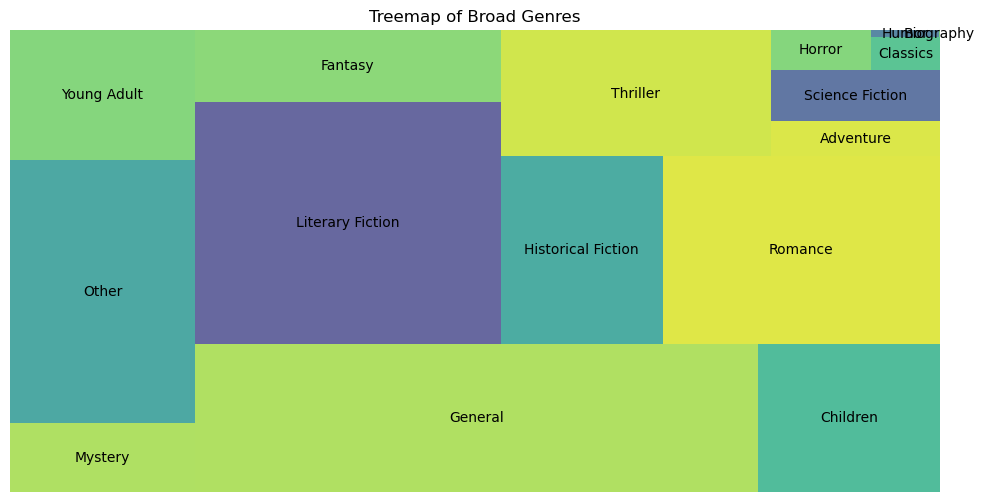

In [43]:
sizes = genre_df['Count']
labels = genre_df['Genre']

plt.figure(figsize=(12, 6))
squarify.plot(sizes=sizes, label=labels, alpha=.8)
plt.title('Treemap of Broad Genres')
plt.axis('off')
plt.show()